tobac example: Tracking isolated convection based on updraft velocity and total condensate
==

This example notebook demonstrates the use of tobac to track isolated deep convective clouds in cloud-resolving model simulation output based on vertical velocity and total condensate mixing ratio.

The simulation results used in this example were performed as part of the ACPC deep convection intercomparison  case study (http://acpcinitiative.org/Docs/ACPC_DCC_Roadmap_171019.pdf) with WRF using the Morrison microphysics scheme. 

The data used in this example is downloaded from "zenodo link" automatically as part of the notebooks (This only has to be done once for all the tobac example notebooks).

**Import libraries:**

In [1]:
# Import a range of python libraries used in this notebook:
import datetime
import shutil
from pathlib import Path
from six.moves import urllib

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Import tobac itself:
import tobac
print('using tobac version', str(tobac.__version__))

using tobac version unknown_dev_version


In [3]:
#Disable a couple of warnings:
import warnings
warnings.filterwarnings('ignore', category=UserWarning, append=True)
warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=FutureWarning, append=True)
warnings.filterwarnings('ignore',category=pd.io.pytables.PerformanceWarning)


**Download and load example data:**   
The actual dowloading is only necessary once for all example notebooks.

In [4]:
data_out=Path('../')

In [5]:
# Download the data: This only has to be done once for all tobac examples and can take a while
data_file = list(data_out.rglob('data/Example_input_midlevelUpdraft.nc'))
if len(data_file) == 0:
    file_path='https://zenodo.org/records/3195910/files/climate-processes/tobac_example_data-v1.0.1.zip'
    #file_path='http://zenodo..'
    tempfile=Path('temp.zip')
    print('start downloading data')
    request=urllib.request.urlretrieve(file_path, tempfile)
    print('start extracting data')
    shutil.unpack_archive(tempfile, data_out)
    tempfile.unlink()
    print('data extracted')
    data_file = list(data_out.rglob('data/Example_input_midlevelUpdraft.nc'))

**Load Data from downloaded file:**

In [6]:
data_file_W_mid_max = list(data_out.rglob('data/Example_input_midlevelUpdraft.nc'))[0]
data_file_TWC = list(data_out.rglob('data/Example_input_Condensate.nc'))[0]

In [7]:
W_mid_max = xr.open_dataset(data_file_W_mid_max).w

In [8]:
TWC = xr.open_dataset(data_file_TWC).twc

In [9]:
# Display information about the two dataarrays for vertical velocity and total condensate mixing ratio:
display(W_mid_max)
display(TWC)

<xarray.DataArray 'w' (time: 47, south_north: 198, west_east: 198)> Size: 7MB
[1842588 values with dtype=float32]
Coordinates:
  * time                (time) datetime64[ns] 376B 2013-06-19T20:05:00 ... 20...
  * south_north         (south_north) int64 2kB 281 282 283 284 ... 476 477 478
  * west_east           (west_east) int64 2kB 281 282 283 284 ... 476 477 478
    bottom_top_stag     int64 8B ...
    latitude            (south_north, west_east) float32 157kB ...
    longitude           (south_north, west_east) float32 157kB ...
    model_level_number  int64 8B ...
    x                   (west_east) float64 2kB ...
    y                   (south_north) float64 2kB ...
    x_0                 (west_east) int64 2kB ...
    y_0                 (south_north) int64 2kB ...
Attributes:
    long_name:     w
    units:         m s-1
    cell_methods:  model_level_number: maximum

<xarray.DataArray 'twc' (time: 47, bottom_top: 94, south_north: 198,
                         west_east: 198)> Size: 693MB
[173203272 values with dtype=float32]
Coordinates:
  * time                (time) datetime64[ns] 376B 2013-06-19T20:05:00 ... 20...
  * bottom_top          (bottom_top) int64 752B 0 1 2 3 4 5 ... 89 90 91 92 93
  * south_north         (south_north) int64 2kB 281 282 283 284 ... 476 477 478
  * west_east           (west_east) int64 2kB 281 282 283 284 ... 476 477 478
    latitude            (south_north, west_east) float32 157kB ...
    longitude           (south_north, west_east) float32 157kB ...
    model_level_number  (bottom_top) int64 752B ...
    x                   (west_east) float64 2kB ...
    y                   (south_north) float64 2kB ...
    x_0                 (west_east) int64 2kB ...
    y_0                 (south_north) int64 2kB ...
Attributes:
    long_name:  TWC
    units:      kg kg-1

**Data visualisation**

We can take a look at our data both by plotting an individual time step, and by plotting a histogram of the values as shown below:


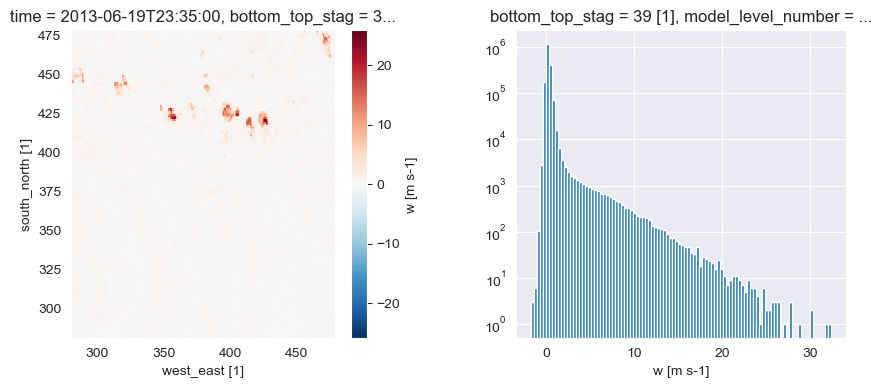

In [10]:
plt.figure(figsize=(10,4))

ax1 = plt.subplot(1,2,1)
W_mid_max[42].plot(ax=ax1)

ax2 = plt.subplot(1,2,2)
W_mid_max.plot(ax=ax2, bins=100)
plt.yscale("log")

plt.subplots_adjust(wspace=0.35)

In [11]:
#Set up directory to save output and plots:
savedir=Path("Save")
if not savedir.is_dir():
    savedir.mkdir()
plot_dir=Path("Plot")
if not plot_dir.is_dir():
    plot_dir.mkdir()

**Feature detection:**

Perform feature detection based on midlevel maximum vertical velocity and a range of threshold values.

In [12]:
# Set temporal and spatial sampling of the input data:
dxy = 500 # meters
dt = 300 # seconds

In [13]:
# Keyword arguments for feature detection step:
parameters_features={}
parameters_features['position_threshold']='weighted_diff'
parameters_features['sigma_threshold']=0.5
parameters_features['min_distance']=0
parameters_features['sigma_threshold']=1
parameters_features['threshold']=[3,5,10] #m/s
parameters_features['n_erosion_threshold']=0
parameters_features['n_min_threshold']=3

In [14]:
# Perform feature detection and save results:
print('start feature detection based on midlevel column maximum vertical velocity')
Features=tobac.feature_detection_multithreshold(W_mid_max,dxy,**parameters_features)
print('feature detection performed start saving features')
Features.to_hdf(savedir / 'Features.h5', 'table')
print('features saved')


start feature detection based on midlevel column maximum vertical velocity
feature detection performed start saving features
features saved


We can also compare the detected features to the input field to judge whether feature detection has done a good job. Below, we can see that the use of multiple thresholds has allowed the most prominent features (green) to be detected, as well as less prominent features surrounding them which may represent earlier stages of convective storms

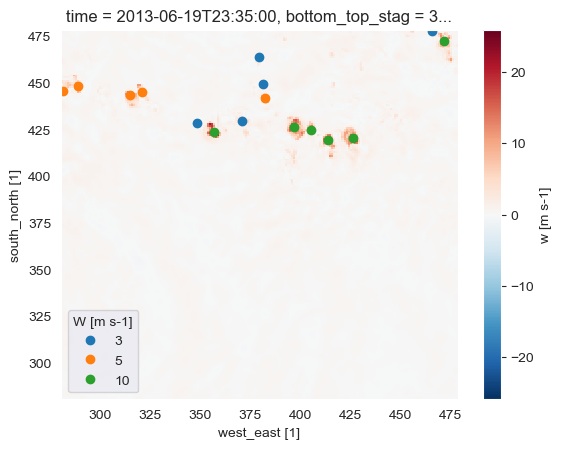

In [15]:
frame=42
W_mid_max[frame].plot()
points = {
    threshold:plt.plot(ft.west_east, ft.south_north, "o")[0]
    for threshold, ft in Features[Features.frame==frame].groupby("threshold_value")
}
plt.legend(list(points.values()), list(points.keys()), title="W [m s-1]")

**Segmentation:**  
Perform segmentation based on 3D total condensate field to determine cloud volumes associated to identified features:

In [16]:
parameters_segmentation_TWC={}
parameters_segmentation_TWC['method']='watershed'
parameters_segmentation_TWC['threshold']=0.1e-3  # kg/kg mixing ratio

In [17]:
print('Start segmentation based on total water content')
Mask_TWC, Features_TWC = tobac.segmentation_3D(Features, TWC, dxy, **parameters_segmentation_TWC)
print('segmentation TWC performed, start saving results to files')
Mask_TWC.to_netcdf(savedir / 'Mask_Segmentation_TWC.nc', encoding={"segmentation_mask":{"zlib":True, "complevel":4}})
Features_TWC.to_hdf(savedir / 'Features_TWC.h5','table')
print('segmentation TWC performed and saved')

Start segmentation based on total water content
segmentation TWC performed, start saving results to files
segmentation TWC performed and saved


**Trajectory linking:**  
Detected features are linked into cloud trajectories using the trackpy library (http://soft-matter.github.io/trackpy). This takes the feature positions determined in the feature detection step into account but does not include information on the shape of the identified objects.

In [18]:
# Keyword arguments for linking step:
parameters_linking={}
parameters_linking['method_linking']='predict'
parameters_linking['adaptive_stop']=0.2
parameters_linking['adaptive_step']=0.95
parameters_linking['extrapolate']=0
parameters_linking['order']=1
parameters_linking['subnetwork_size']=100
parameters_linking['memory']=0
parameters_linking['time_cell_min']=5*60
parameters_linking['method_linking']='predict'
parameters_linking['v_max']=10


In [19]:
# Perform linking and save results:
Track=tobac.linking_trackpy(Features,W_mid_max,dt=dt,dxy=dxy,**parameters_linking)
Track.to_hdf(savedir / 'Track.h5', 'table')


**Visualisation:**  

In [20]:
# Set extent for maps plotted in the following cells ( in the form [lon_min,lon_max,lat_min,lat_max])
axis_extent=[-95,-93.8,29.5,30.6]        

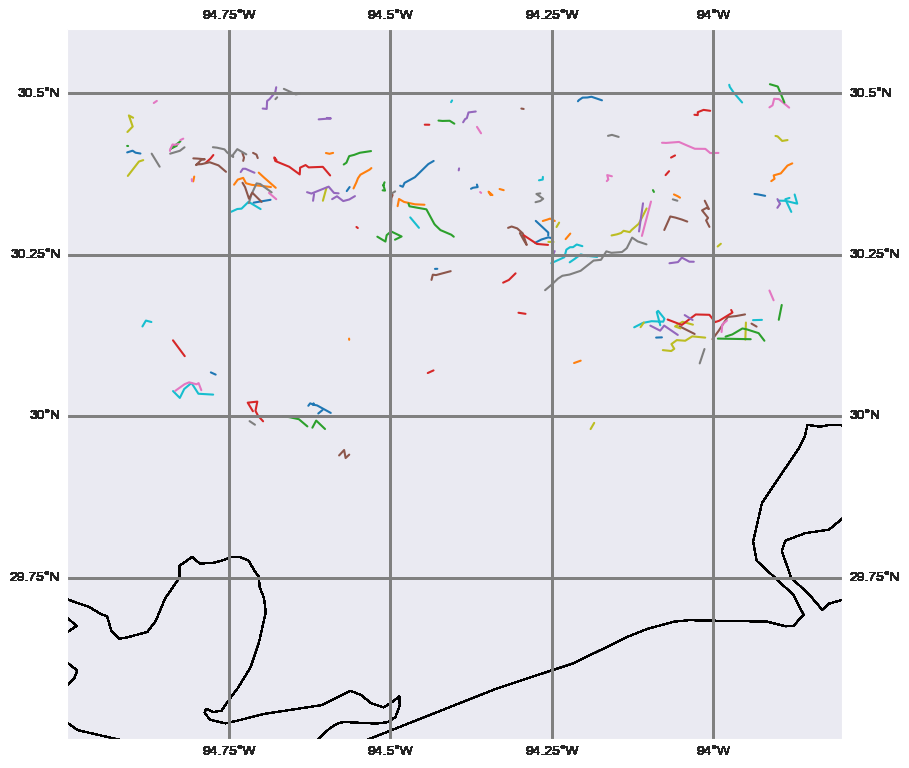

In [21]:
# Plot map with all individual tracks:
import cartopy.crs as ccrs
fig_map,ax_map=plt.subplots(figsize=(10,10),subplot_kw={'projection': ccrs.PlateCarree()})
ax_map=tobac.map_tracks(Track,axis_extent=axis_extent,axes=ax_map)

Text(0, 0.5, 'counts')

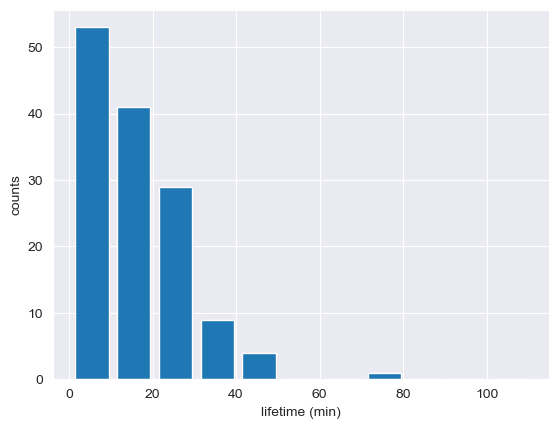

In [22]:
# Updraft lifetimes of tracked cells:
fig_lifetime,ax_lifetime=plt.subplots()
tobac.plot_lifetime_histogram_bar(Track,axes=ax_lifetime,bin_edges=np.arange(0,120,10),density=False,width_bar=8)
ax_lifetime.set_xlabel('lifetime (min)')
ax_lifetime.set_ylabel('counts')
         

In [23]:
# Create animation showing tracked cells with outline of cloud volumes and the midlevel vertical velocity as a background field:
animation_tobac=tobac.animation_mask_field(
    track=Track,features=Features,field=W_mid_max,mask=Mask_TWC,
    axis_extent=axis_extent,
    vmin=0,vmax=20,extend='both',cmap='Blues',
    interval=500,figsize=(10,7),
    plot_outline=True,plot_marker=True,marker_track='x',plot_number=True,plot_features=True
)

In [24]:
# Display animation:
from IPython.display import HTML, Image, display
HTML(animation_tobac.to_html5_video())

<Figure size 640x480 with 0 Axes>